In [1]:
from matplotlib import pyplot as plt
import numpy as np

import os
import PIL

import random

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

if torch.cuda.is_available():
  print("Using GPU!")
  device = torch.device("cuda")
else:
  print("Using CPU")
  device = torch.device("cpu")

Using GPU!


In [37]:
expanded_dataset = False
path = "_2" if expanded_dataset else ""

In [25]:
def get_all_types():
    with open('pokemon_data/pokemon' + path + '.csv', 'r') as pokemon_list:
        types = set()
        
        for line in pokemon_list:
            types.update(set(line.strip().split(',')[1:]))
            
        types.difference_update(['', 'Type1', 'Type2'])
        
    return list(types)

In [26]:
def get_all_data(_type_to_id, _num_types):
    with open('pokemon_data/pokemon' + path + '.csv','r') as pokemon_list:
        output = []
        for line in list(pokemon_list)[1:]: 
            csv_data = line.strip().split(',')
            
            y = torch.zeros(_num_types)
            for types in csv_data[1:]:
                if types != '':
                    y[_type_to_id[types]] = 1
                    
            output.append((csv_data[0], y))
            
    return output[1:]

In [71]:
batch_size = 20

types = get_all_types()
num_types = len(types)
id_to_type = {i: val for i, val in enumerate(types)}
type_to_id = {val: i for i, val in enumerate(types)}

all_data = get_all_data(type_to_id, num_types)
random.shuffle(all_data)
image_list, type_list = list(zip(*all_data))

image_batch, type_batch = [], []
for i in range(0, len(image_list), batch_size):
    image_batch.append(image_list[i:i+batch_size])
    type_batch.append(type_list[i:i+batch_size])

split1 = round(len(image_batch) * .6)
split2 = split1 + round(len(image_batch) * .2)
train_image, train_type = image_batch[:split1], type_batch[:split1]
test_image, test_type = image_batch[split1:split2], type_batch[split1:split2]
dev_image, dev_type = image_batch[split2:], type_batch[split2:]

num_epochs = 15

In [27]:
def get_image(image_names):
    images = []
    for image_name in image_names:
        image = PIL.Image.open(os.path.join('pokemon_data/images' + path, image_name+'.png'))
        if len(image.size) == 2:
            image = image.convert('RGBA')
        images.append(torch.tensor(np.transpose(np.asarray(image.resize((120,120))) / 255.0, (2, 0, 1)))
                      .float()[:3,:,:])
    
    return torch.stack(images)

In [ ]:
class PokemonModel(nn.Module):
    def __init__(self):
        super(PokemonModel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(128, 256, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4)
        )
        self.lin = nn.Sequential(
            nn.Linear(256, num_types),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        cnn = self.main(x)
        cnn_flat = torch.reshape(cnn, [-1, 256])
        out = self.lin(cnn_flat)
        
        return out        

In [ ]:
# model = PokemonModel()
model = models.vgg16(pretrained=True)

# Freeze all layers
for p in model.parameters():
    p.requires_grad = False

# Define new classifier layer. This layer will not be frozen
new_classifier = nn.Sequential(
                    nn.Linear(25088, num_types, bias=True),
                    nn.Sigmoid()
                )

model._modules['classifier'] = new_classifier

model.to(device)

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    for x, y in tqdm(zip(train_image, train_type)):
        img_x = get_image(x).reshape((-1, 3, 120, 120)).to(device)
        img_y = torch.stack(y).to(device)
        model.zero_grad()
        
        output = model.forward(img_x)
        loss = criterion(output, img_y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        loss = 0
        for x, y in zip(dev_image, dev_type):
            img_x = get_image(x).reshape((-1, 3, 120, 120)).to(device)
            img_y = torch.stack(y).to(device)
            output = model.forward(img_x)
            loss += criterion(output, img_y)
            
        print("Epoch:", epoch+1, "Dev Loss:", loss.item())

23it [01:06,  2.89s/it]


Epoch: 1 Dev Loss: 28.94965934753418


23it [01:18,  3.42s/it]


Epoch: 2 Dev Loss: 28.50078773498535


23it [01:31,  3.96s/it]


Epoch: 3 Dev Loss: 28.271095275878906


23it [01:31,  3.96s/it]


Epoch: 4 Dev Loss: 28.095481872558594


23it [01:31,  3.96s/it]


Epoch: 5 Dev Loss: 27.988183975219727


23it [01:31,  3.96s/it]


Epoch: 6 Dev Loss: 27.921533584594727


23it [01:31,  3.96s/it]


Epoch: 7 Dev Loss: 27.877859115600586


23it [01:31,  3.96s/it]


Epoch: 8 Dev Loss: 27.847637176513672


In [74]:
# Test data

correct_ct = 0
test_image_flat = [i for batch in test_image for i in batch]
test_type_flat = [i for batch in test_type for i in batch]
for x, y in tqdm(zip(test_image_flat, test_type_flat)):
    with torch.no_grad():
        img_x = get_image([x]).reshape((-1, 3, 120, 120)).to(device)
        img_y = y.to(device)
        
        output = model.forward(img_x)            
        v, i = output.topk(2)
        type1 = i.squeeze()[0].item()
        type2 = i.squeeze()[1].item() if v.squeeze()[1] > 0.8 else None
        
        if y[type1] == 1:
#             if (type2 and y[type2] == 1) or not type2:
            correct_ct += 1
#                 print(x, id_to_type[type1], id_to_type[type2] if type2 else None)
            
print("Accuracy", correct_ct/len(test_image_flat))

1600it [00:52, 30.37it/s]

Accuracy 0.5825


In [66]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 120, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120, 120 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 2, 120 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 4, 120 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 8, 1, 4, 4, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        cnn = self.main(input)
        return cnn

d = Discriminator().to(device)
d_optimizer = optim.Adam(d.parameters(), lr=1e-4)

In [67]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 120 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(120 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(120 * 8, 120 * 4, 8, 3, 1, bias=False),
            nn.BatchNorm2d(120 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(120 * 4, 120 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(120 * 2, 120, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120),
            nn.ReLU(True),
            nn.ConvTranspose2d(120, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

g = Generator().to(device)
g_optimizer = optim.Adam(g.parameters(), lr=1e-3)

In [68]:
def train_discriminator(x):
  d_optimizer.zero_grad()

  real_output = d.forward(x)
  # real_y = torch.zeros(real_output.shape[0]).to(device)
  real_y = torch.rand(real_output.size(0), device=device) * 0.1
  real_loss = nn.BCELoss()(real_output.squeeze(), real_y)
  
  noise = torch.randn(batch_size, 100, 1, 1).to(device)
  fake_x = g.forward(noise)

  gen_output = d.forward(fake_x)
  # gen_y = torch.ones(fake_x.shape[0]).to(device)
  gen_y = torch.rand(fake_x.size(0), device=device) * 0.1 + 0.9
  gen_loss = nn.BCELoss()(gen_output.squeeze(), gen_y)

  total_loss = real_loss + gen_loss
  total_loss.backward()
  d_optimizer.step()

  return total_loss

In [69]:
def train_generator():
    g_optimizer.zero_grad()
    
    # Generate fake data
    noise = torch.randn(batch_size, 100, 1, 1).to(device)
    fake_x = g.forward(noise)
    
    # Test against the discriminator
    disc_output = d.forward(fake_x)
    targets = torch.zeros(fake_x.shape[0]).to(device) # We want the discriminator to think these images are real.
    loss = nn.BCELoss()(disc_output.squeeze(), targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    g_optimizer.step()

    return loss

27it [00:27,  1.01s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 Disc Loss: 15.296409606933594 Gen Loss: 91.91336059570312


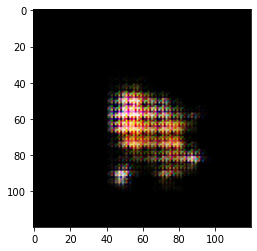

27it [00:27,  1.00s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 Disc Loss: 14.268318176269531 Gen Loss: 84.99937438964844


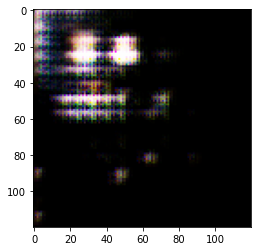

27it [00:27,  1.00s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3 Disc Loss: 13.930819511413574 Gen Loss: 86.97684478759766


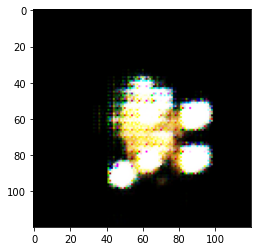

27it [00:27,  1.00s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4 Disc Loss: 14.203365325927734 Gen Loss: 91.51348114013672


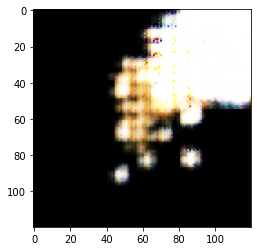

27it [00:26,  1.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5 Disc Loss: 13.142184257507324 Gen Loss: 99.07600402832031


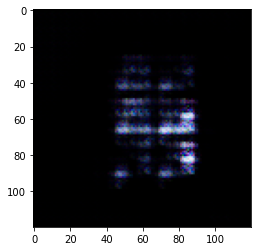

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 6 Disc Loss: 14.468040466308594 Gen Loss: 96.92095184326172


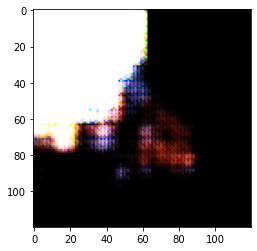

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7 Disc Loss: 13.45103645324707 Gen Loss: 93.51150512695312


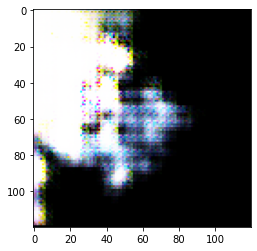

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8 Disc Loss: 14.23808479309082 Gen Loss: 90.53512573242188


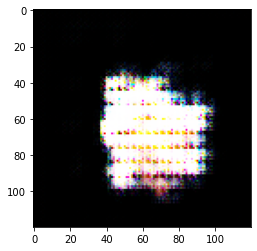

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9 Disc Loss: 12.540295600891113 Gen Loss: 93.20771789550781


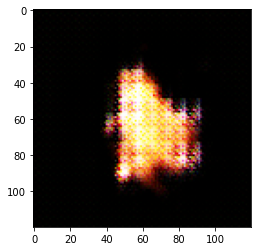

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10 Disc Loss: 13.910629272460938 Gen Loss: 96.63045501708984


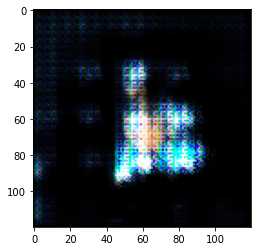

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11 Disc Loss: 12.992895126342773 Gen Loss: 91.47789001464844


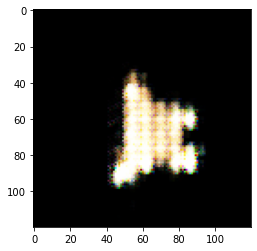

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12 Disc Loss: 13.11069107055664 Gen Loss: 92.30088806152344


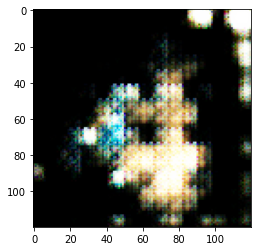

27it [00:26,  1.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 13 Disc Loss: 15.121018409729004 Gen Loss: 101.82877349853516


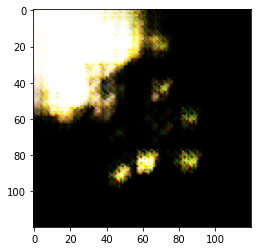

27it [00:26,  1.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 14 Disc Loss: 13.059442520141602 Gen Loss: 88.24066162109375


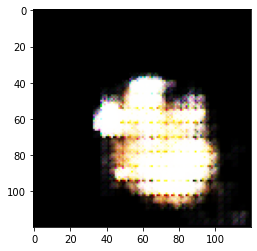

27it [00:26,  1.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15 Disc Loss: 12.500018119812012 Gen Loss: 88.589111328125


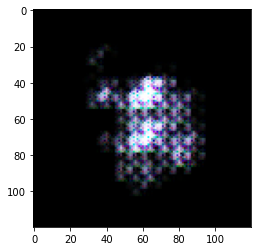

In [110]:
# Real = 0, Fake = 1
for epoch in range(num_epochs):
  d_loss = 0
  g_loss = 0
  for x, y in tqdm(zip(train_image, train_type)):
    img_x = get_image(x).reshape((-1, 3, 120, 120)).to(device)
    img_y = torch.stack(y).to(device)
    
    d_loss += train_discriminator(img_x)
    g_loss += train_generator()
        
            
  print("Epoch:", epoch+1, "Disc Loss:", d_loss.item(), "Gen Loss:", g_loss.item())

  noise = torch.randn(batch_size, 100, 1, 1).to(device)
  fake_x = g.forward(noise)
  plt.imshow(fake_x.cpu().detach()[0].permute((1, 2, 0)))
  plt.show()